In [2]:
from datasets import load_dataset

ds = load_dataset("detection-datasets/coco")

Generating val split: 100%|██████████| 4952/4952 [00:05<00:00, 986.68 examples/s] 


In [15]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import io
from datasets import load_dataset
from datasets import concatenate_datasets, DatasetDict,load_from_disk

In [14]:



all_data = concatenate_datasets([ds['train'], ds['val']])
total_samples = len(all_data)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

def preprocess_images(batch):
    processed_images = []
    for img in batch["image"]:
     
        if isinstance(img, Image.Image):
            image = img.convert("RGB")
        elif isinstance(img, str):
            image = Image.open(img).convert("RGB")
        elif isinstance(img, bytes):
            image = Image.open(io.BytesIO(img)).convert("RGB")
        elif isinstance(img, np.ndarray):
            image = Image.fromarray(img).convert("RGB")
        else:
            continue  
        processed_images.append(transform(image))
    batch["image"] = processed_images
    return batch


all_data = all_data.map(preprocess_images, batched=True, batch_size=32)

Map: 100%|██████████| 122218/122218 [38:20<00:00, 53.12 examples/s] 



In [16]:

all_data.save_to_disk("./preprocessed_all_data")
print("Dataset saved to ./preprocessed_all_data")

Saving the dataset (148/148 shards): 100%|██████████| 122218/122218 [14:01<00:00, 145.28 examples/s]

Dataset saved to ./preprocessed_all_data


In [ ]:

loaded_data = load_from_disk("./preprocessed_all_data")
print(loaded_data)

train_val_split = all_data.train_test_split(test_size=0.3, seed=42)  # 70% train, 30% temp
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)  # Split 30% into 15%/15%

balanced_ds = DatasetDict({
    'train': train_val_split['train'],     
    'val': val_test_split['train'],        
    'test': val_test_split['test']    
})

print(f"Balanced splits:")
print(f"Train: {len(balanced_ds['train'])} samples")
print(f"Validation: {len(balanced_ds['val'])} samples")  
print(f"Test: {len(balanced_ds['test'])} samples")


Map:   0%|          | 0/122218 [00:00<?, ? examples/s]



RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [10]:
print(balanced_ds['train'][:5])

{'image_id': [345625, 313655, 358174, 329717, 402908], 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x468 at 0x21632857490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=335x500 at 0x21632821540>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x216328224A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x358 at 0x21632822680>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x438 at 0x21632822F20>], 'width': [640, 335, 640, 500, 640], 'height': [468, 500, 480, 358, 438], 'objects': [{'bbox_id': [128986, 163110, 240973, 410893, 412050, 412147, 412321, 1233114, 1296720, 1312486, 1313425, 1318451, 1320960, 1327721, 1328267, 1330473, 1330578, 1332258, 1336588, 1382064, 1384887, 1710388, 2002298, 2046396, 2168125, 900100345625], 'category': [1, 5, 1, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 0, 0, 2, 1, 0], 'bbox': [[65.35, 273.81, 84.03999999999999, 303.98], [119.62, 42.96, 468.09000000000003, 408.09999999

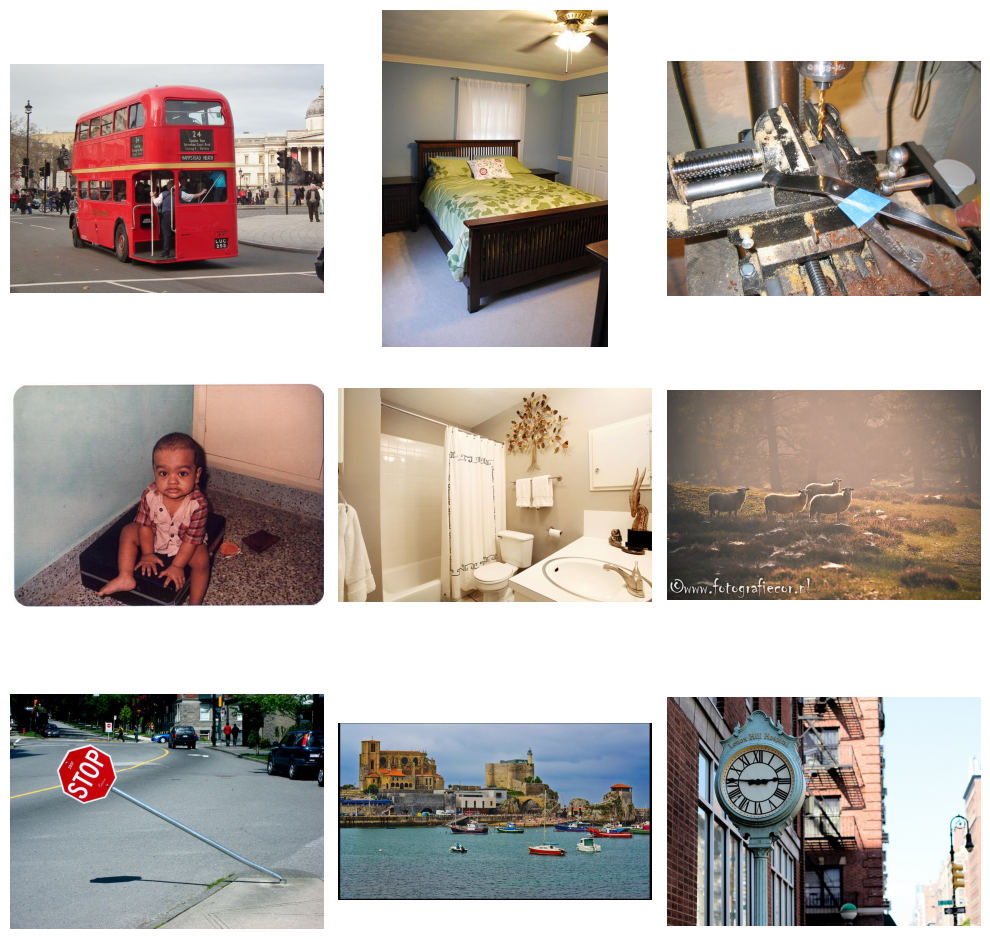

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io


num_images = 9
images = balanced_ds['train']['image'][:num_images]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = images[i]
    
    if isinstance(img, str):
        img = Image.open(img)
    
    elif isinstance(img, bytes):
        img = Image.open(io.BytesIO(img))
    
    ax.imshow(np.array(img))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Save the preprocessed all_data dataset locally
all_data.save_to_disk("./preprocessed_all_data")
print("Dataset saved to ./preprocessed_all_data")